In [1]:
# New Evaluation Metric

import cv2
import numpy as np
from shapely.geometry import Polygon
from skimage.draw import polygon as draw_polygon
from skimage.draw import line as draw_line
from scipy.ndimage import binary_erosion, binary_dilation
from skimage.io import imread, imshow, imsave
import matplotlib.pyplot as plt

def reverse_padding(array, padding):
    return array[padding:-padding, padding:-padding]

def draw_circle(center, r, array, px_value=2):
    array_size = array.shape
    y, x = np.ogrid[:array_size[0], :array_size[1]]
    cir = (x - center[0])**2 + (y - center[1])**2 <= r**2
    array[cir] = px_value
    return array

def rasterize(inp_obj, array_size = None, centroids = False, draw_centroids = False):
    if array_size is None:
        array = None
    else:
        array = np.zeros(array_size)
        array = np.pad(array, 1)
    def rasterize_single_polygon(obj, array):
        nonlocal array_size
        if obj.type == 'LineString':
            boundary_coords = np.array(obj.coords)
            if array is None:
                max1 = max([np.max(el) for el in boundary_coords]).astype('int') + 2
                array_size = (max1, max1)
                array = np.zeros(array_size, dtype=np.uint8)
            boundary_coords[:, [0, 1]] = boundary_coords[:, [1, 0]]  # Swap x and y coordinates
            for i in range(len(boundary_coords) - 1):
                start_point = boundary_coords[i].astype('int')
                end_point = boundary_coords[i + 1].astype('int')
                rr, cc = draw_line(start_point[0], start_point[1], end_point[0], end_point[1])
                rr = np.clip(rr, 0, array_size[0] - 1)
                cc = np.clip(cc, 0, array_size[1] - 1)
                array[rr, cc] = 1
        elif obj.type == 'Polygon':
            xy = np.array(obj.exterior.coords)
            rr, cc = draw_polygon(xy[:, 1], xy[:, 0])
            if array is None:
                max1 = max([np.max(el) for el in xy]).astype('int') + 2
                array_size = (max1, max1)
                array = np.zeros(array_size, dtype=np.uint8)
            array[rr, cc] = 1
        return array

    centroid_array=[]
    if (type(inp_obj) == list) or (type(inp_obj) == tuple):
        if array is None:
            xy_g = [np.array(obj.exterior.coords) for obj in inp_obj]
            max_dim = max([np.max(el) for el in xy_g]).astype('int') + 2
            array_size = (max_dim, max_dim)
            array = np.zeros(array_size, dtype=np.uint8)
        for obj in inp_obj:
            array = rasterize_single_polygon(obj, array=array)
            centroid_array.append(list(obj.centroid.coords)[0])
            if draw_centroids:
#                 centroid_array.append(list(obj.centroid.coords)[0])
                array = draw_circle(list(obj.centroid.coords)[0], 4, array, px_value=0.5)
    else:
        array = rasterize_single_polygon(inp_obj, array=array)
        centroid_array.append(list(obj.centroid.coords)[0])
        if draw_centroids:
            array = draw_circle(list(inp_obj.centroid.coords)[0], 4, array, px_value=2)
    array = reverse_padding(array, 1)
    if centroids:
        return (array*255).astype('uint8'), centroid_array
    else:
        return (array*255).astype('uint8')
def rasterize_no_erosion(obj, array=None):
    if obj.type == 'LineString':
        boundary_coords = np.array(obj.coords)
        if array is None:
            max1 = max([np.max(el) for el in boundary_coords]).astype('int') + 1
            array_size = (max1, max1)
            array = np.zeros(array_size, dtype=np.uint8)
        boundary_coords[:, [0, 1]] = boundary_coords[:, [1, 0]]  # Swap x and y coordinates
        for i in range(len(boundary_coords) - 1):
            start_point = boundary_coords[i].astype('uint8')
            end_point = boundary_coords[i + 1].astype('uint8')
            rr, cc = draw_line(start_point[0], start_point[1], end_point[0], end_point[1])
            rr = np.clip(rr, 0, array_size[0] - 1)
            cc = np.clip(cc, 0, array_size[1] - 1)
            array[rr, cc] = 1
    elif obj.type == 'Polygon':
        xy = np.array(obj.exterior.coords)
        rr, cc = draw_polygon(xy[:, 1], xy[:, 0])
        if array is None:
            max1 = max([np.max(el) for el in xy]).astype('int') + 1
            array_size = (max1, max1)
            array = np.zeros(array_size, dtype=np.uint8)
        array[rr, cc] = 1
    return array

def polygonize(mask, erosion=0):
    if erosion>0:
        mask = binary_erosion(mask, iterations=erosion).astype('uint8')
    elif erosion<0:
        mask = binary_dilation(mask, iterations=(erosion)*(-1)).astype('uint8')
    binary_image = mask.copy()
    binary_image = np.pad(binary_image, 2)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image)
    threshold_area = 10
    polygons = []
    bps=[]
    for label in range(1, num_labels):
        roi = (labels == label).astype(np.uint8)
        contour, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if cv2.contourArea(contour[0]) < threshold_area:
            continue
        boundary_coordinates = np.squeeze(contour[0]).tolist()
        if len(boundary_coordinates)>2:
            bps.append(boundary_coordinates)
            polygon = Polygon(boundary_coordinates)
            polygons.append(polygon.convex_hull)
    return polygons

def global_dice_score(binary_image1, binary_image2):
    intersection = np.logical_and(binary_image1, binary_image2)
    dice = 2 * np.sum(intersection) / (np.sum(binary_image1) + np.sum(binary_image2))
    return dice

def global_iou_score(binary_image1, binary_image2):
    intersection = np.logical_and(binary_image1, binary_image2)
    iou = np.sum(intersection) / (np.sum(binary_image1) + np.sum(binary_image2))
    return iou

#     global rroo
#     rroo = []
def evaluate(polygons_gt, polygons_p):
    int_uni = []
    scores = []
    for poly_gt in polygons_gt:
        intersect_flag=False
        if poly_gt.type == 'LineString':
            poly_gt = Polygon(poly_gt)
        for poly_p in polygons_p:
            if poly_p.type == 'LineString':
                poly_p = Polygon(poly_p)
            if (poly_gt.intersects(poly_p)):# and (poly_p.area > 10):
                intersect_flag=True
                inter = poly_gt.intersection(poly_p)
                union = poly_gt.union(poly_p)
                c_gt = poly_gt.centroid
                c_p = poly_p.centroid
                scores.append([(1/(1+c_p.distance(c_gt))), inter.area/union.area]) # centroids, iou
#                     if (1/(1+c_p.distance(c_gt))) < 0.9:
#                         rroo.append(poly_p)
#                 break  #<-- if there is more than one predicted piece to a uniform general piece
        if intersect_flag == False:
            scores.append([0,0])   ## if there is no intersection---zero accuracy (False Negative)
    scores = np.array(scores)
    cents_err = np.average(scores[:,0])
    iou = np.average(scores[:,1])
    return np.array([cents_err, iou, scores],dtype='object')


# IoU = |A ∩ B| / |A ∪ B|
# Dice = (2 * |A ∩ B|) / (|A| + |B|)

def local_iou(im_gt, im_pred):
    polygons_gt = polygonize(im_gt, erosion=0)
    polygons_p = polygonize(im_pred, erosion=0)
    if (len(polygons_gt)==0):
            #False positive
            pass
    if (len(polygons_p)==0):
        #False negative
        pass
    imx_gt = rasterize(polygons_gt, array_size=(500,500), centroids = False)
    imx_pred = rasterize(polygons_p, array_size=(500,500), centroids = False)

    global_dice = global_dice_score(imx_gt/255, imx_pred/255)
    giou = global_iou_score(imx_gt/255, imx_pred/255)
    scores = evaluate(polygons_gt, polygons_p)
#     res = {'global iou:': giou, 'centroids:':scores[0], 'local iou:':scores[1]}
    return np.array([giou, scores[0], scores[1]])
#     return res

def local_err(predictions, targets):
    def normalize_to_255(array):
        min_value = np.min(array)
        max_value = np.max(array)
        if max_value == min_value:
            if max_value>0.5:
                return (np.ones_like(array)*255).astype(np.uint8)
            else:
                return (np.zeros_like(array)).astype(np.uint8)
        else:
            scaled_array = ((array - min_value) / (max_value - min_value)) * 255
            return scaled_array[0].astype(np.uint8)

        num_processes = os.cpu_count()
        predictions_np = predictions.detach().cpu().numpy()
        targets_np = targets.detach().cpu().numpy()

        pred_chunks = torch.chunk(predictions.detach(), num_processes, dim=0)
        pred_chunks = [p[0].cpu().numpy() for p in pred_chunks]

        gt_chunks = torch.chunk(targets.detach(), num_processes, dim=0)
        gt_chunks = [p[0].cpu().numpy() for p in gt_chunks]

        pred_chunks_255 = list(map(normalize_to_255, pred_chunks))
        gt_chunks_255 = list(map(normalize_to_255, gt_chunks))

        batch_pairs = np.hstack((np.expand_dims(np.array(pred_chunks_255), axis = 1), np.expand_dims(np.array(gt_chunks_255), axis = 1)))
        results = list(map(lambda pair: local_iou(pair[0], pair[1]), batch_pairs))
        results = np.array(results)
        avg_errors = np.mean(results, axis=0)
        return torch.tensor(2-avg_errors[2])


# imp = 'https://img.freepik.com/free-vector/abstract-pattern-background-black-striped-design-vector_53876-151304.jpg?w=2000&t=st=1689812434~exp=1689813034~hmac=9e8f10bb0744be430267e3b2bec91a777338fe009d826d958293def79466ff08'
# imp1 = imread(imp)

# imp2 = imp1[0:500,0:500,0]
# imshow(imp2)

# local_iou(imp2,np.rot90(imp2))


In [2]:
import os
from skimage.io import imread, imshow, imsave
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.draw import line
from skimage.morphology import skeletonize
import pymorph
import mahotas as mh
from scipy import spatial
from bresenham import bresenham
import pandas as pd
import networkx as nx
import cv2
import numpy as np
from collections import deque
from scipy.ndimage import label, find_objects
import pickle
import os
import concurrent.futures

def grapher_cent(tp, out, clean=False, pad=True):
    global b2
    def skel_to_graph(skeIm, connectivity=2):
        assert(len(skeIm.shape) == 2)
        skeImPos = np.stack(np.where(skeIm))
        skeImPosIm = np.zeros_like(skeIm, dtype=np.int32)
        skeImPosIm[skeImPos[0], skeImPos[1]] = np.arange(0, skeImPos.shape[1])
        g = nx.Graph()
        if connectivity == 1:
            neigh = np.array([[0, 1], [0, -1], [1, 0], [-1, 0]])
        elif connectivity == 2:
            neigh = np.array([[0, 1], [0, -1], [1, 0], [-1, 0], [1, 1], [1, -1], [-1, 1], [-1, -1]])
        else:
            raise ValueError(f'unsupported connectivity {connectivity}')
        for idx in range(skeImPos[0].shape[0]):
            for neighIdx in range(neigh.shape[0]):
                curNeighPos = skeImPos[:, idx] + neigh[neighIdx]
                if np.any(curNeighPos<0) or np.any(curNeighPos>=skeIm.shape):
                    continue
                if skeIm[curNeighPos[0], curNeighPos[1]] > 0:
                    g.add_edge(skeImPosIm[skeImPos[0, idx], skeImPos[1, idx]], skeImPosIm[curNeighPos[0], curNeighPos[1]], weight=np.linalg.norm(neigh[neighIdx]))
        return g
    
    
    def skeletonizer(img):
        (thresh, bw) = cv2.threshold(img, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        skeleton_lee = skeletonize(bw, method='lee')
        return skeleton_lee
    
    def branchedPoints(skel):
        branch1=np.array([[2, 1, 2], [1, 1, 1], [2, 2, 2]])
        branch2=np.array([[1, 2, 1], [2, 1, 2], [1, 2, 1]])
        branch3=np.array([[1, 2, 1], [2, 1, 2], [1, 2, 2]])
        branch4=np.array([[2, 1, 2], [1, 1, 2], [2, 1, 2]])
        branch5=np.array([[1, 2, 2], [2, 1, 2], [1, 2, 1]])
        branch6=np.array([[2, 2, 2], [1, 1, 1], [2, 1, 2]])
        branch7=np.array([[2, 2, 1], [2, 1, 2], [1, 2, 1]])
        branch8=np.array([[2, 1, 2], [2, 1, 1], [2, 1, 2]])
        branch9=np.array([[1, 2, 1], [2, 1, 2], [2, 2, 1]])
        br1=mh.morph.hitmiss(skel,branch1)
        br2=mh.morph.hitmiss(skel,branch2)
        br3=mh.morph.hitmiss(skel,branch3)
        br4=mh.morph.hitmiss(skel,branch4)
        br5=mh.morph.hitmiss(skel,branch5)
        br6=mh.morph.hitmiss(skel,branch6)
        br7=mh.morph.hitmiss(skel,branch7)
        br8=mh.morph.hitmiss(skel,branch8)
        br9=mh.morph.hitmiss(skel,branch9)
        return br1+br2+br3+br4+br5+br6+br7+br8+br9
    
    def endPoints(skel):
        endpoint1=np.array([[0, 0, 0],
                            [0, 1, 0],
                            [2, 1, 2]])
        
        endpoint2=np.array([[0, 0, 0],
                            [0, 1, 2],
                            [0, 2, 1]])
        
        endpoint3=np.array([[0, 0, 2],
                            [0, 1, 1],
                            [0, 0, 2]])
        
        endpoint4=np.array([[0, 2, 1],
                            [0, 1, 2],
                            [0, 0, 0]])
        
        endpoint5=np.array([[2, 1, 2],
                            [0, 1, 0],
                            [0, 0, 0]])
        
        endpoint6=np.array([[1, 2, 0],
                            [2, 1, 0],
                            [0, 0, 0]])
        
        endpoint7=np.array([[2, 0, 0],
                            [1, 1, 0],
                            [2, 0, 0]])
        
        endpoint8=np.array([[0, 0, 0],
                            [2, 1, 0],
                            [1, 2, 0]])
        
        endpoint9=np.array([[0, 0, 0],
                            [0, 1, 0],
                            [0, 0, 0]])
        
        ep1=mh.morph.hitmiss(skel,endpoint1)
        ep2=mh.morph.hitmiss(skel,endpoint2)
        ep3=mh.morph.hitmiss(skel,endpoint3)
        ep4=mh.morph.hitmiss(skel,endpoint4)
        ep5=mh.morph.hitmiss(skel,endpoint5)
        ep6=mh.morph.hitmiss(skel,endpoint6)
        ep7=mh.morph.hitmiss(skel,endpoint7)
        ep8=mh.morph.hitmiss(skel,endpoint8)
        ep9=mh.morph.hitmiss(skel,endpoint9)
        ep = ep1+ep2+ep3+ep4+ep5+ep6+ep7+ep8+ep9
        return ep
    def pruning(skeleton, size):
    
        for i in range(0, size):
            endpoints = endPoints(skeleton)
            endpoints = np.logical_not(endpoints)
            skeleton = np.logical_and(skeleton,endpoints)
        return skeleton
    
    def shuffle(a):
        a = list(a)
        random.shuffle(a)
        return a 
    def normalize(arr, upper_bound=255, uint8 = True):
        if arr.max() != arr.min():
            if uint8:
                return ((arr - arr.min())*(upper_bound/(arr.max()-arr.min()))).astype('uint8')
            else:
                return (arr - arr.min())*(upper_bound/(arr.max()-arr.min()))
        else:
            if uint8:
                return arr.astype('uint8')
            else: 
                return arr
    
    def detect_tails2(mask, ep_val=3, bp_vals=[2], out_px_value=5, min_line_length=10):
        mask_bi = cv2.threshold(mask, 0, 1, 8)
        mask = mask_bi[1]
        skel = mh.thin(mask)
        skel = pruning(skel,3)
        bp = branchedPoints(skel)
        ep = endPoints(skel)
        edge = skel-bp
        bps = np.where(bp>0, 1, 0)
        eps = np.where(ep>0, 2, 0)
        combined = bps+eps+skel #ep_val becomes 3 here as a result of combination
        data = combined.copy()
        ep_coords = np.argwhere(data == ep_val)
        lines=dict()
        for p in ep_coords:
            lines.update({f'{list(p)}':[]})
        for point in ep_coords:
            center = point
            lines[f'{list(center)}'].append(list(point))
            no_bp = True
            counter = 0
            while no_bp:
                counter+=1
                tl = [point[0]-1, point[1]-1]
                t = [point[0]-1, point[1]]
                tr = [point[0]-1, point[1]+1]
                l = [point[0], point[1]-1]
                c = [point[0], point[1]]
                r = [point[0], point[1]+1]
                bl = [point[0]+1, point[1]-1]
                b = [point[0]+1, point[1]]
                br = [point[0]+1, point[1]+1]
                ker = [t, r, b, l]
                try:
                    for j in ker:
                        if (data[j[0], j[1]] ==1) & (list(j) not in lines[f'{list(center)}']):
                            lines[f'{list(center)}'].append(list(j))
                            point = j
                        elif data[j[0], j[1]] in bp_vals: #branch points
                            no_bp = False
                    if counter > len(data):
                        no_bp = False
                except:
                    no_bp = False
        filterred_lines = {}
        eliminated_lines = {}
        for key in lines.keys():
            for p in lines[key]:
                if len(lines[key])>=3:
                    if len(lines[key])>=min_line_length:
                        data[p[0],p[1]] = out_px_value
                        filterred_lines.update({key:lines[key]})
                    else:
                        data[p[0],p[1]] = 0
                        ind = list(np.array(key.replace(' ', '').replace('[', '').replace(']', '').split(',')).astype(int))
                        combined[ind[0], ind[1]]=4
                        eliminated_lines.update({key:lines[key]})
                else:
                    data[p[0],p[1]] = 0
                    
        return combined, data, filterred_lines, eliminated_lines
    
    
    def closeness_loss2(mask, min_line_length=1):
        img, data, lines, eliminated_lines = detect_tails2(mask, ep_val=3, bp_vals=[2], out_px_value=5, min_line_length=min_line_length)
        leaves = len(np.where(img==3)[0])
        branch_points = len(np.where(img==2)[0])
        if branch_points != 0:
            ratio = (leaves/branch_points)*10
            y = 1-(np.e**(-3*ratio))
        else:
            y = 1
        return [leaves, len(np.where(img==1)[0]), ratio, y]
    
    def dynamic_threshold(mask):
        if len(mask.shape) == 3:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        _, binary_mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return binary_mask
    
    def collapse_twos(grid):
        grid0 = grid.copy()
        structure = np.ones((3, 3), dtype=int)  
        labeled_array, num_features = label(grid == 2, structure=structure)
        for i in range(1, num_features + 1):
            slices = find_objects(labeled_array == i)[0]
            top_left = (slices[0].start, slices[1].start)
            grid[labeled_array == i] = 0
            grid[top_left] = 2
        grid1 = np.where((grid + grid0)>3,1,0) + np.where(grid0>0,1,0)
        grid1 = grid1.astype(np.uint8)
        return grid1
    
    def pad_one(image):
        image[0, :] = 255
        image[-1, :] = 255
        image[:, 0] = 255
        image[:, -1] = 255
        return image
    
    import numpy as np
    from collections import deque
    from scipy.ndimage import label, find_objects
    import networkx as nx
    
    def proximity_checker(mask, point, start, end):
        tl = [point[0]-1, point[1]-1]
        t = [point[0]-1, point[1]]
        tr = [point[0]-1, point[1]+1]
        l = [point[0], point[1]-1]
        c = [point[0], point[1]]
        r = [point[0], point[1]+1]
        bl = [point[0]+1, point[1]-1]
        b = [point[0]+1, point[1]]
        br = [point[0]+1, point[1]+1]
        ker = [t, r, b, l, tl, tr, bl, br]
        flag = False
        for j in ker:
            if 0 <= j[0] < mask.shape[0] and 0 <= j[1] < mask.shape[1]:
                if (mask[j[0], j[1]] ==2) & ((j[0], j[1]) != end) & ((j[0], j[1]) != start):
                    flag = True
        return flag
    
    def bfs(start, end, grid):
        if start == end:
            return True
        rows, cols = grid.shape
        queue = deque([start])
        visited = set()
        visited.add(start)
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (1,1), (-1,1), (1,-1), (-1,-1)]
        while queue:
            x, y = queue.popleft()
            for dx, dy in directions:
                nx, ny = x + dx, y + dy
                if 0 <= nx < rows and 0 <= ny < cols and (nx, ny) not in visited and not proximity_checker(grid, (nx, ny), start, end):
                    if (nx, ny) == end:
                        return True
                    if grid[nx][ny] == 1:
                        visited.add((nx, ny))
                        queue.append((nx, ny))
        return False
    
    def find_connections(grid):
        vertices = np.argwhere(grid == 2)
        results = []
        for i in range(len(vertices)):
            for j in range(i + 1, len(vertices)):
                if bfs(tuple(vertices[i]), tuple(vertices[j]), grid):
                    results.append((tuple(vertices[i]), tuple(vertices[j]), 1))
                else:
                    results.append((tuple(vertices[i]), tuple(vertices[j]), 0))
        return results


    def create_graph_cent(gt_mask_padded):
        gt_mask_padded2 = gt_mask_padded.max()-gt_mask_padded
        gt_mask_padded2 = np.where(gt_mask_padded2>100, 255, 0).astype('uint8')
        polygon_list = polygonize(gt_mask_padded2, erosion=1)
        im, centroid_array= rasterize(polygon_list, array_size = gt_mask_padded2.shape, centroids = True, draw_centroids = False)
        G = nx.Graph()
        for i, poly in enumerate(polygon_list):
            G.add_node(i, pos=poly.centroid.coords[0])
        for i, poly1 in enumerate(polygon_list):
            for j, poly2 in enumerate(polygon_list):
                if i < j and poly1.buffer(2).intersects(poly2.buffer(2)):
                    G.add_edge(i, j)
        pos = nx.get_node_attributes(G, 'pos')
        with open(f'graphs/{out}/graph_cent/{p[:-4]}.pickle', 'wb') as f:
            pickle.dump((G, pos), f)
        return G, pos

    tim = imread(tp)
    inp = dynamic_threshold(tim)
    p = tp.split('/')[-1]
    if pad:
        inp = pad_one(inp)
        
    a, b, c, d = detect_tails2(inp, ep_val=3, bp_vals=[2], out_px_value=5, min_line_length=0)
            
    if clean:
        b2 = np.where(b==5, 0 , b)
    else:
        b2 = np.where(a==1, 1, 0) + np.where(a>1, 2, 0)

    
    b2_collapsed = collapse_twos(b2.copy())
    mask = np.where(b2>0, 255, 0)
    # mask = np.where(b2_collapsed>0, 1, 0)
    
    G, pos = create_graph_cent(mask)
    # with open(f'graphs/{out}/graph_cent/{p[:-4]}.pickle', 'wb') as f:
    #     pickle.dump((G, pos), f)

    with open(f'gt_cent.pickle', 'wb') as f:
        pickle.dump((G, pos), f)

    # imsave(f'graphs/{out}/mask/{p[:-4]}.png', b2_collapsed)

    # with open(f'disconnected_clover5.pickle', 'wb') as f:
    #     pickle.dump((G, pos), f)
    # imsave(f'graphs/{out}/mask/{p[:-4]}.png', b2_collapsed)


# tp = "graphs/padded_dirty_simple/mask/46_m.png"
# grapher_cent(tp, out="padded_dirty_simple", clean=False, pad=True)

def process_path(p):
    tp = f"topo/gen_start_scale=0/{p}"
    grapher_cent(tp, out="padded_cleaned_topo", clean=True, pad=True)
    
    sp = f"simple/gen_start_scale=0/{p}"
    grapher_cent(sp, out="padded_dirty_simple", clean=False, pad=True)


# t_paths = [p for p in os.listdir('topo/gen_start_scale=0') if p.endswith('m.png')]
# with concurrent.futures.ProcessPoolExecutor() as executor:
#     count = 0
#     with open('count_log-parallel2_cent.txt', 'a') as filelog:
#         for _ in executor.map(process_path, t_paths):
#             count += 1
#             filelog.write(f'{count}, ')
#             filelog.flush()



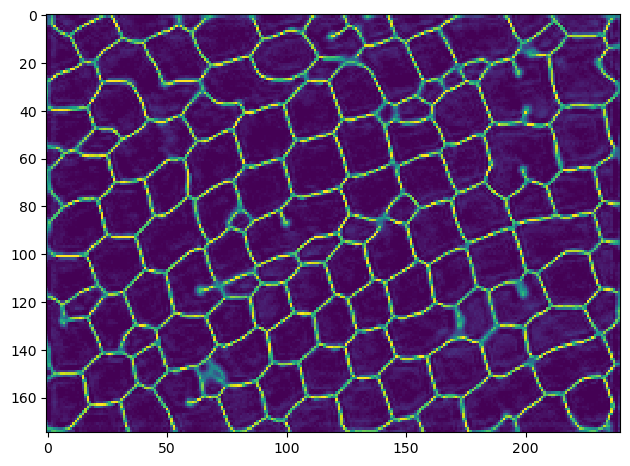

In [3]:
topo_dendro_p = "/mmfs1/home/jacks.local/mohsen.ahmadkhani/imageprocessing/singan/outputs/toposamples/Output_1029/RandomSamples/dendro_skel/gen_start_scale=0/"
import os
c = 0
for f in os.listdir(topo_dendro_p):
    if f.endswith('m.png'):
        c+=1
        img = imread(topo_dendro_p + f)
        break

imshow(img)

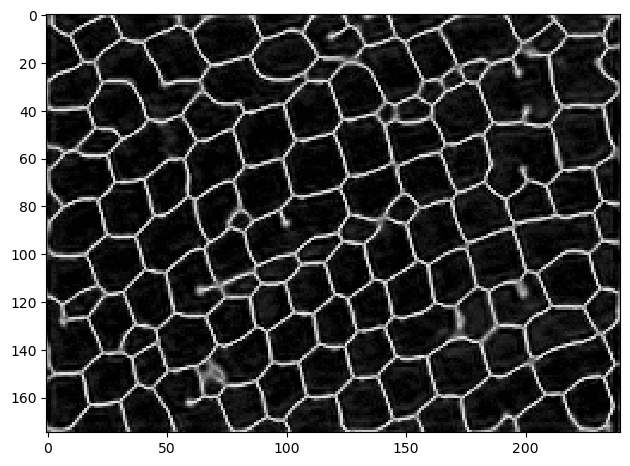

In [7]:
imshow(img[:,:,1])



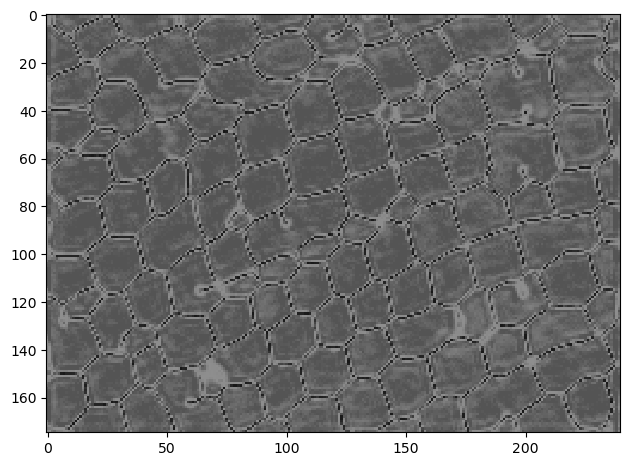

In [13]:
imshow(img[:,:,2])


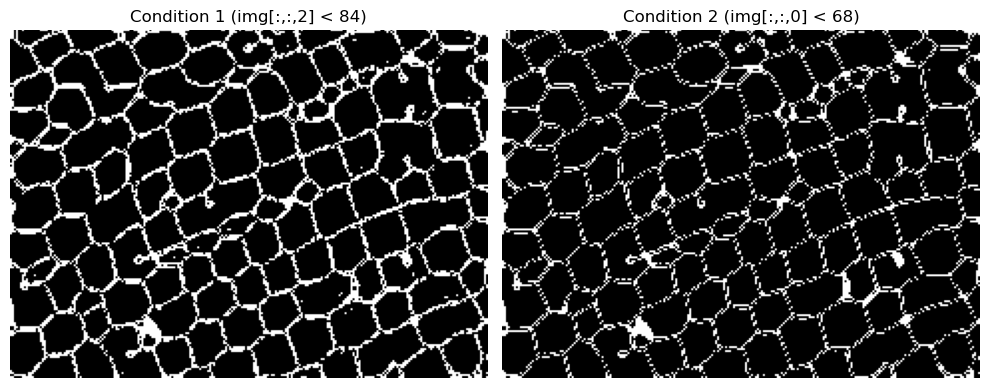

In [56]:
import numpy as np
import matplotlib.pyplot as plt

condition1 = np.where(((img[:, :, 2] > 125) | (img[:, :, 2] < 84)), 1, 0)
condition2 = np.where(img[:, :, 0] < 68, 1, 0)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(condition1, cmap='gray')
axes[0].set_title('Condition 1 (img[:,:,2] < 84)')
axes[1].imshow(condition2, cmap='gray')
axes[1].set_title('Condition 2 (img[:,:,0] < 68)')
for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()


/mmfs1/cm/shared/apps_local/python/3.11/envs/torch2.2/lib/python3.12/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


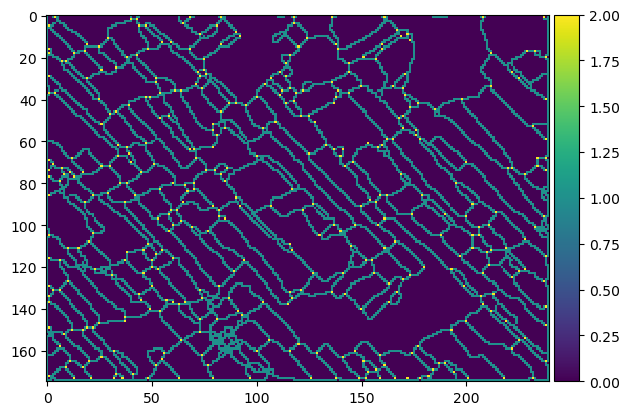

In [25]:
pg1 = "graphs/padded_cleaned_topo/mask/"
for p in os.listdir(pg1):
    imshow(pg1+p)
    break

In [ ]:
# pg1 = "graphs/padded_dirty_simple/graph_cent/"
pg1 = "graphs/padded_cleaned_topo/graph_cent/"
for p in os.listdir(pg1):
    with open(pg1+p, 'rb') as f:
        G1, pos1 = pickle.load(f)
        
    nx.draw(G1, pos1, with_labels=False, node_size=50, node_color='red', edge_color='blue')
    plt.show()

In [8]:

grapher_cent("clover175x240.png", out="padded_cleaned_topo", clean=False, pad=True)



/tmp/ipykernel_3292296/253745712.py:30: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if obj.type == 'LineString':
/tmp/ipykernel_3292296/253745712.py:44: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif obj.type == 'Polygon':


In [16]:
import networkx as nx
import matplotlib.pyplot as plt
from tabulate import tabulate
import math
import collections
def add_node0(G1, pos1):
    G1p = G1.copy()
    pos1p = pos1.copy()
    existing_node = list(G1p.nodes())
    new_node_id = (existing_node[0], existing_node[1] + 1)
    G1p.add_node(new_node_id)
    G1p.add_edge(new_node_id, existing_node)
    new_node_position = (pos1p[existing_node][0], pos1p[existing_node][1] - 20)
    pos1p[new_node_id] = new_node_position
    return [G1p, pos1p]
    
def max_cycles3_count(n):
    return math.factorial(n) / (math.factorial(n-3) * math.factorial(3))
def normalized_closeness_centrality(G):
    N = len(G)
    closeness_centrality = nx.closeness_centrality(G)
    normalized_centrality = {node: (N-1) * centrality for node, centrality in closeness_centrality.items()}
    return normalized_centrality

def average_harmonic_centrality(G):
    harmonic_centrality_values = nx.harmonic_centrality(G)
    return sum(harmonic_centrality_values.values()) / len(harmonic_centrality_values)

def cl_cn(G):
    closeness_centrality = nx.closeness_centrality(G)
    normalized_closeness_centrality = {}
    n = len(G)
    for node in G.nodes:
        sum_of_distances = sum(nx.shortest_path_length(G, source=node).values())
        if sum_of_distances > 0:  # Avoid division by zero
            normalized_closeness_centrality[node] = (n-1) / sum_of_distances
        else:
            normalized_closeness_centrality[node] = 0
    return normalized_closeness_centrality
        
# Function to calculate metrics
def calculate_metrics(G):
    # Basic metrics
    cycles = list(nx.cycle_basis(G))
    density = nx.density(G)
    normalized_cycles = len(cycles) / (G.number_of_nodes() * density) if density > 0 else 0
    
    path_length = nx.average_shortest_path_length(G) if nx.is_connected(G) else float('inf')
    clustering_coeff = nx.average_clustering(G)
    degree_counts = nx.degree_histogram(G)
    num_degree_0 = degree_counts[0] if len(degree_counts) > 0 else 0
    num_degree_1 = degree_counts[1] if len(degree_counts) > 1 else 0
    num_degree_greater_than_1 = sum(degree_counts[2:]) if len(degree_counts) > 2 else 0
    num_components = nx.number_connected_components(G)
    
    # Centrality measures
    betweenness = nx.betweenness_centrality(G)
    closeness = nx.closeness_centrality(G)
    # eigenvector = nx.eigenvector_centrality(G, max_iter=1000)
    
    # Additional metrics
    network_diameter = nx.diameter(G) if nx.is_connected(G) else float('inf')
    assortativity = nx.degree_assortativity_coefficient(G)
    modularity = nx.algorithms.community.modularity(G, nx.algorithms.community.label_propagation_communities(G))

    L = nx.laplacian_matrix(G).astype(float)
    eigenvalues = np.linalg.eigvalsh(L.A)
    eigenvalues.sort()
    zero_eigenvalues = np.count_nonzero(eigenvalues == 0)
    if zero_eigenvalues < len(eigenvalues) - 1:
        fiedler_value = eigenvalues[zero_eigenvalues + 1]
        spectral_gap = eigenvalues[zero_eigenvalues + 2] - fiedler_value
    else:
        fiedler_value = 0
        spectral_gap = 0

    return {
        "Number of Components": num_components,
        "Number of Cycles": len(cycles),
        "Normalized # of Cycles_old": 10000 * len(cycles) / max_cycles3_count(G.number_of_nodes()),
        "Normalized # of Cycles": normalized_cycles,
        "Num of Cycles / Num of Nodes": len(cycles) / G.number_of_nodes() ,
        "Density": 100*density, # Density = 2 x # of Edges/((# of nodes)x(# of nodes -1))
        # "Average Path Length": path_length,
        "Clustering Coefficient": clustering_coeff,
        "Number of Nodes with Degree 0": num_degree_0,
        "Number of Nodes with Degree 1": num_degree_1,
        "Number of Nodes with Degree > 1": num_degree_greater_than_1,
        "Betweenness Centrality": sum(betweenness.values())/10,
        "Closeness Centrality": (sum(nx.closeness_centrality(G).values())),
        # "Closeness Centrality": np.average(list(cl_cn(G).values())), #/G.number_of_nodes(),
        # "Closeness Centrality": average_harmonic_centrality(G),
        # "Eigenvector Centrality": sum(eigenvector.values()),
        # "Network Diameter": network_diameter,
        "Assortativity": assortativity,
        "Modularity": modularity,
        "fiedler_value": fiedler_value*100,
        "spectral_gap": spectral_gap*100,
        # "Smallest Laplacian Eigenvalue": min(laplacian_spectrum)
    }



In [18]:
import pickle
import networkx as nx
pg1 = 'gt_cent.pickle'
with open(pg1, 'rb') as f:
    G1, pos1 = pickle.load(f)

# Gl1 = add_node0(G1, pos1)

pd.DataFrame([calculate_metrics(G1)])

/tmp/ipykernel_3292296/4227212816.py:67: VisibleDeprecationWarning: `.A` is deprecated and will be removed in v1.14.0. Use `.toarray()` instead.
  eigenvalues = np.linalg.eigvalsh(L.A)


,Number of Components,Number of Cycles,Normalized # of Cycles_old,Normalized # of Cycles,Num of Cycles / Num of Nodes,Density,Clustering Coefficient,Number of Nodes with Degree 0,Number of Nodes with Degree 1,Number of Nodes with Degree > 1,Betweenness Centrality,Closeness Centrality,Assortativity,Modularity,fiedler_value,spectral_gap
0,1,44,12.857978,12.601942,0.733333,5.819209,0.525122,0,8,52,0.319345,15.445822,-0.247793,0.514327,5.537417,8.082992


In [19]:
# pd.DataFrame([metrics_g1, metrics_g2, metrics_g3])

dirs = ['graphs/padded_dirty_simple/graph_cent/', 'graphs/padded_cleaned_topo/graph_cent/']
root_p = dirs[1]
results = []
for g in os.listdir(root_p):
    if not g.startswith('.'):
        with open(root_p+g, 'rb') as f:
            G, pos = pickle.load(f)
        # Gl = add_node0(G, pos)
        metrics = calculate_metrics(G)
        results.append(metrics)
        
res_df_tp = pd.DataFrame(results)
res_df_tp.describe().iloc[1:3, :]


/tmp/ipykernel_3292296/4227212816.py:67: VisibleDeprecationWarning: `.A` is deprecated and will be removed in v1.14.0. Use `.toarray()` instead.
  eigenvalues = np.linalg.eigvalsh(L.A)


,Number of Components,Number of Cycles,Normalized # of Cycles_old,Normalized # of Cycles,Num of Cycles / Num of Nodes,Density,Clustering Coefficient,Number of Nodes with Degree 0,Number of Nodes with Degree 1,Number of Nodes with Degree > 1,Betweenness Centrality,Closeness Centrality,Assortativity,Modularity,fiedler_value,spectral_gap
mean,1.176471,189.392157,2.512360,44.694996,1.105764,2.528793,0.402427,0.156863,3.372549,166.960784,0.595103,25.428444,-0.062892,0.605860,2.919310,4.172834
std,0.517914,27.054817,1.511852,5.607912,0.085345,0.499830,0.029558,0.504878,1.660853,19.762551,0.062098,2.041886,0.050425,0.027735,1.369617,1.261857


In [20]:
# pd.DataFrame([metrics_g1, metrics_g2, metrics_g3])

dirs = ['graphs/padded_dirty_simple/graph_cent/', 'graphs/padded_cleaned_topo/graph_cent/']
root_p = dirs[0]
results = []
for g in os.listdir(root_p):
    if not g.startswith('.'):
        with open(root_p+g, 'rb') as f:
            G, pos = pickle.load(f)
        # Gl = add_node0(G, pos)
        metrics = calculate_metrics(G)
        results.append(metrics)
        
res_df = pd.DataFrame(results)
res_df.describe().iloc[1:3, :]


/tmp/ipykernel_3292296/4227212816.py:67: VisibleDeprecationWarning: `.A` is deprecated and will be removed in v1.14.0. Use `.toarray()` instead.
  eigenvalues = np.linalg.eigvalsh(L.A)


,Number of Components,Number of Cycles,Normalized # of Cycles_old,Normalized # of Cycles,Num of Cycles / Num of Nodes,Density,Clustering Coefficient,Number of Nodes with Degree 0,Number of Nodes with Degree 1,Number of Nodes with Degree > 1,Betweenness Centrality,Closeness Centrality,Assortativity,Modularity,fiedler_value,spectral_gap
mean,1.120000,157.400000,4.214916,35.806852,1.188726,3.331648,0.448532,0.080000,2.500000,129.86000,0.446191,25.284222,-0.075895,0.598742,5.120903,5.709089
std,0.328261,12.389923,0.611467,2.407642,0.058472,0.241268,0.024280,0.274048,1.474269,8.78777,0.041155,1.705475,0.043557,0.021896,2.184944,1.621145


/tmp/ipykernel_3292296/4227212816.py:67: VisibleDeprecationWarning: `.A` is deprecated and will be removed in v1.14.0. Use `.toarray()` instead.
  eigenvalues = np.linalg.eigvalsh(L.A)


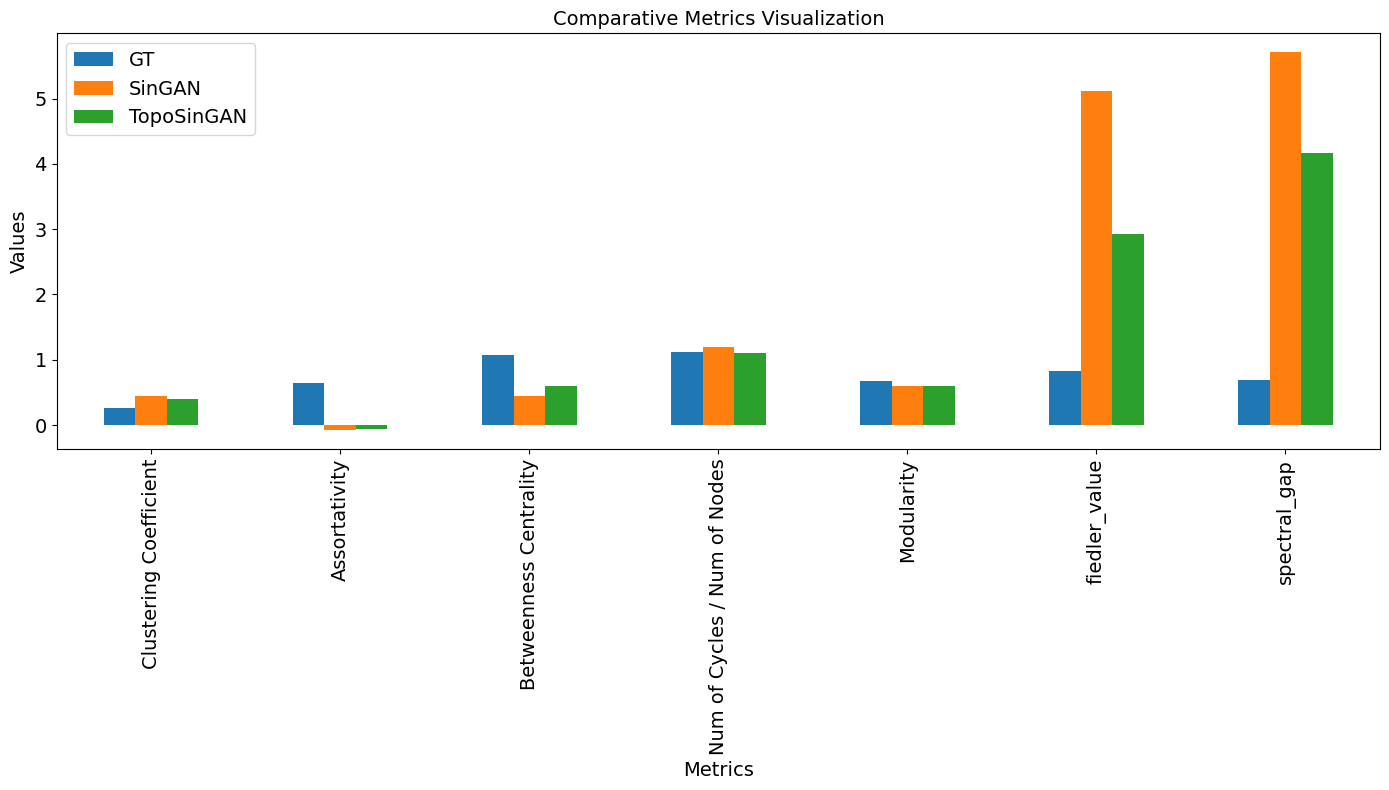

In [24]:


df_concat = pd.concat([pd.DataFrame([calculate_metrics(Gl1[0])]).iloc[:, :], res_df.describe().iloc[1:2, :], 
                       res_df_tp.describe().iloc[1:2, :]], keys=['GT', 'SinGAN', 'TopoSinGAN'])

df_concat = df_concat[["Number of Components" ,"Number of Cycles","Number of Nodes with Degree 0",
                       "Number of Nodes with Degree > 1" ,"Number of Nodes with Degree 1" , "Normalized # of Cycles", 
                       "Closeness Centrality", "Clustering Coefficient" ,"Assortativity", "Betweenness Centrality",
                       "Num of Cycles / Num of Nodes","Modularity", "fiedler_value", "spectral_gap"]]
           
# Plotting
ax = df_concat.iloc[:,7:].T.plot(kind='bar', figsize=(14, 8), fontsize=14)

# Set titles and labels
plt.title('Comparative Metrics Visualization', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.xlabel('Metrics', fontsize=14)
plt.xticks(rotation=90)

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['GT', 'SinGAN', 'TopoSinGAN'], fontsize=14)

plt.tight_layout()
plt.show()


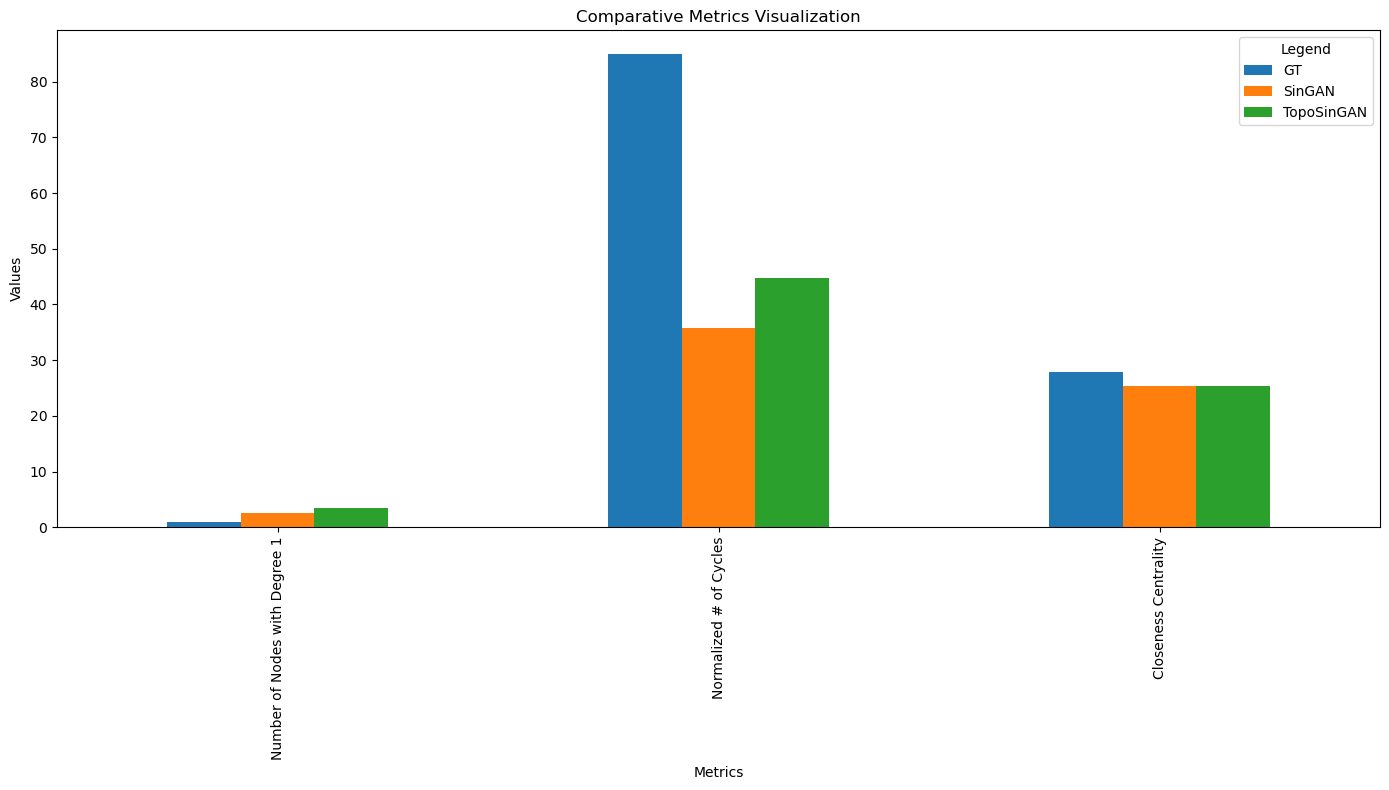

In [23]:

ax = df_concat.iloc[:,4:7].T.plot(kind='bar', figsize=(14, 8))

# Set titles and labels
plt.title('Comparative Metrics Visualization')
plt.ylabel('Values')
plt.xlabel('Metrics')
plt.xticks(rotation=90)

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['GT', 'SinGAN', 'TopoSinGAN'], title='Legend')

plt.tight_layout()

# Show the plot
plt.show()


In [22]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity


similarity_matrix = cosine_similarity(df_concat.iloc[:,7:-2])
similarity_to_first_row = similarity_matrix[0, 1:]  # Similarity of second and third rows to the first row

print(f"Similarity score of the second row to the first row: {similarity_to_first_row[0]}")
print(f"Similarity score of the third row to the first row: {similarity_to_first_row[1]}")


Similarity score of the second row to the first row: 0.8472450520139763
Similarity score of the third row to the first row: 0.8860539774201122
